In [87]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.misc import imread

colnames = [
    'square_id', 'time_interval', 'country_code','SMS_in',
    'SMS_out', 'Call_in','Call_out', 'Internet_traffic'
    ]
used = ['square_id', 'Call_in','Call_out']
reader = pd.read_csv('cdr/sms-call-internet-mi-2013-12-31.txt', 
	sep='\t', chunksize=1000, names=colnames, usecols=used)

In [85]:
# prepare activity dataframe to receive total acitvities (Calls in/out)

colnames = ['mgrid_row', 'mgrid_column', 'Call_in', 'Call_out']
activity = pd.DataFrame(columns=colnames, index=np.arange(1,10001)).fillna(0.0)

# construct the Grid
mgrid = np.asarray([range(i, i+100) for i in range(1, 10001, 100)])
mgrid = [mgrid[i] for i in reversed(range(0,len(mgrid)))]

# fill activity dataframe
count = 0
for chunk in reader:
	# get sums for unique square ids within chunk
	sums = chunk.groupby('square_id', as_index=False).sum()
	# fill corresponding activity
	count += len(chunk)
	for sid in sums['square_id']:
		activity.ix[sid]['Call_in'] += float(
			sums[sums['square_id'] == sid]['Call_in'])
		activity.ix[sid]['Call_out'] += float(
			sums[sums['square_id'] == sid]['Call_out'])
		activity.ix[sid]['mgrid_row'] = np.where(mgrid == sid)[0][0] + 1
		activity.ix[sid]['mgrid_column'] = np.where(mgrid == sid)[1][0] + 1

# fill sids for any squares with no activity:
for sid, row in activity[activity['mgrid_row'] == 0].iterrows():
	activity.ix[sid]['mgrid_row'] = np.where(mgrid == sid)[0][0] + 1
for sid, row in activity[activity['mgrid_column'] == 0].iterrows():
	activity.ix[sid]['mgrid_column'] = np.where(mgrid == sid)[1][0] + 1

activity['Call_in'] = activity['Call_in'].map(lambda num: num/(count/10000.0))
activity['Call_out'] = activity['Call_in'].map(lambda num: num/(count/10000.0))

# heat map plotting:
ticks = ['' for idx in activity["mgrid_row"]]

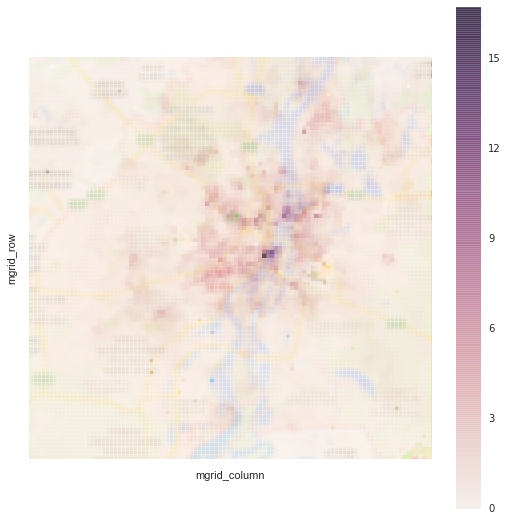

In [91]:
# Using the map of Kyiv as a background for heatmap
plt.figure(figsize=(9,9))
activity1 = activity.pivot("mgrid_row", "mgrid_column", "Call_in")

from PIL import Image
img = Image.open('kyiv55.jpg')
img.thumbnail((136, 136), Image.ANTIALIAS) # resizes image map
imgplot = plt.imshow(img)

sns.heatmap(activity1, linewidth=0,alpha=0.7, xticklabels=ticks,yticklabels=ticks,zorder=1)
plt.show()